In [1]:
#输出文档中的所有的标题
#用于编辑docx文档的时候可以直接更具这个设置标题的样式
#进行函数的封装
def getDocTitle(filename):
    from pdfminer.pdfparser import PDFParser
    from pdfminer.pdfdocument import PDFDocument
    # Open a PDF document.
    fp = open(filename, 'rb')
    parser = PDFParser(fp)
    document = PDFDocument(parser, '')
    #定义一个存储输出结果的变量
    tit_res = []
    # Get the outlines of the document.
    outlines = document.get_outlines()
    for (level,title,dest,a,se) in outlines:
        tit_res.append([level, title])
    return tit_res
getDocTitle('0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf')

[[1, 'Introduction'],
 [2, 'Generating Instrument Timbres'],
 [2, 'Effective Audio Representations for GANs'],
 [2, 'Contributions'],
 [1, 'Experimental Details'],
 [2, 'Dataset'],
 [2, 'Architecture and Representations'],
 [1, 'Metrics'],
 [1, 'Results'],
 [1, 'Qualitative Analysis'],
 [2, 'Phase Coherence'],
 [2, 'Interpolation'],
 [2, 'Consistent Timbre Across Pitch'],
 [1, 'Fast Generation'],
 [1, 'Related Work'],
 [1, 'Conclusion'],
 [1, 'Measuring Diversity across Generated Examples'],
 [1, 'Timbral Similarity Across Pitch'],
 [1, 'Baseline Model Comparisons'],
 [1, 'Training Details']]

file: -f, pages: 17, objects: 503
extracted images:%d run time:%f


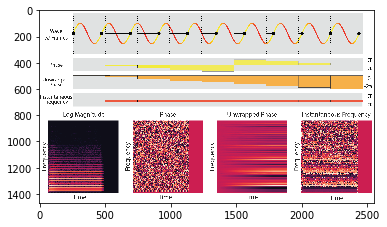

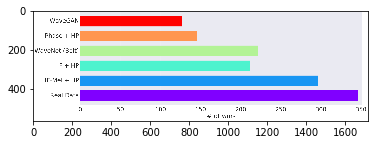

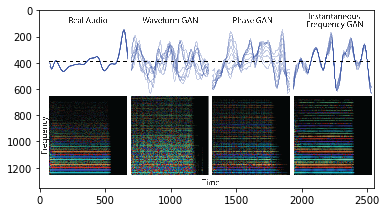

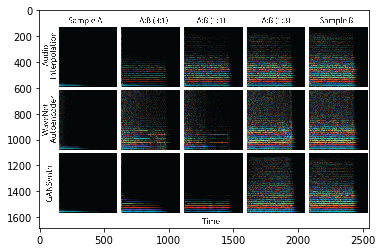

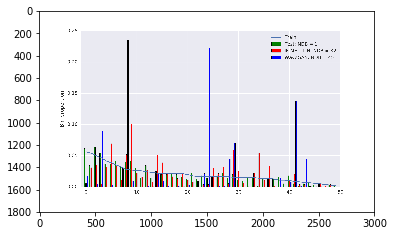

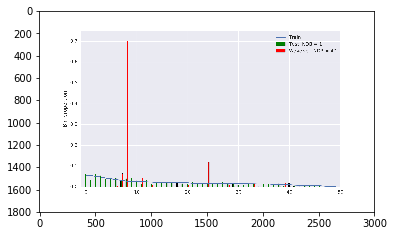

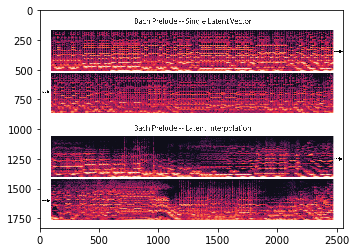

In [11]:
#抽取文档中的图片保存到本地
from __future__ import print_function
import fitz
import sys, time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series,DataFrame

def recoverpix(doc, item):
    x = item[0]  # xref of PDF image
    s = item[1]  # xref of its /SMask
    pix1 = fitz.Pixmap(doc, x)
    if s == 0:                    # has no /SMask
        return pix1               # no special handling
    pix2 = fitz.Pixmap(doc, s)    # create pixmap of /SMask entry
    # check that we are safe
    if not (pix1.irect == pix2.irect and pix1.alpha == pix2.alpha == 0 and pix2.n == 1):
        print("pix1", pix1, "pix2", pix2)
    pix = fitz.Pixmap(pix1)       # copy of pix1, alpha channel added
    pix.setAlpha(pix2.samples)    # treat pix2.samples as alpha value
    pix1 = pix2 = None            # free temp pixmaps
    return pix

t0 = time.clock()
doc = fitz.open('0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf')           # the PDF
imgcount = 0                           # counts extracted images
xreflist = []                          # records images already extracted
lenXREF = doc._getXrefLength()         # only used for information

# display some file info
print("file: %s, pages: %s, objects: %s" % (sys.argv[1], len(doc), lenXREF-1))

for i in range(len(doc)):
    imglist = doc.getPageImageList(i)
    for img in imglist:
        if img[0] in xreflist:         # this image has been processed
            continue 
        xreflist.append(img[0])        # take note of the xref
        pix = recoverpix(doc, img[:2]) # make pixmap from image
        if pix.n - pix.alpha < 4:      # can be saved as PNG
            pass
        else:                          # must convert CMYK first
            pix0 = fitz.Pixmap(fitz.csRGB, pix)
            pix = pix0
        pix.writePNG("images/%s.png" % (img[7]))
        imgcount += 1
        pix = None                     # free Pixmap resources

t1 = time.clock()
print("extracted images:%d run time:%f".format(imgcount,round(t1-t0, 2)))
#打印抽取结果
for i in range(50):
    try:
        imgs = plt.imread('images/Im{0}.png'.format(i))
        plt.imshow(imgs)
        plt.show()
    except:
        pass

In [12]:
#向文档中添加标题
def addTitle(title,leval):
    doc.add_heading(title, leval)

In [13]:
#向文档中添加文本
def addText(text,style):
    if style == 'bold':
        doc.add_paragraph().add_run(text).bold = True
    elif style == 'italic':
        doc.add_paragraph().add_run(text).italic = True

In [14]:
#向文档中添加图片
def addImg(filepath,size):
    doc.add_picture(filepath, width=Inches(size))

In [15]:
#向文档中添加段落
def addParagraph(text):
    doc.add_paragraph(text)

In [16]:
#操作函数化
def editDoc(file):
    from docx.shared import Pt
    from docx import Document
    from docx.shared import Inches
    document = Document()
    return document

In [17]:
#Google翻译函数化
def translateGoogle(seqList,transTo):
    res = []
    from googletrans import Translator
    translator = Translator()
    translator = Translator(service_urls=[
         'translate.google.cn'
        ])
    translations_long = translator.translate(seqList, dest=transTo)
    for translation in translations_long:
        res.append(translation.text)
    return ''.join(res)

In [44]:
#使用百度翻译处理文本
import re
import urllib.parse, urllib.request
import hashlib
import urllib
import random
import json
import time
from translate import *
appid = '20190405000284798'
secretKey = 'J4qn2KPMiwtZCoEQjSkB'
url_baidu = 'http://api.fanyi.baidu.com/api/trans/vip/translate'

def translateBaidu(text, f='en', t='zh'):
    salt = random.randint(1000000000, 9999999999)
    sign = appid + text + str(salt) + secretKey
    sign = hashlib.md5(sign.encode()).hexdigest()
    url = url_baidu + '?appid=' + appid + '&q=' + urllib.parse.quote(text) + '&from=' + f + '&to=' + t +  '&salt=' + str(salt) + '&sign=' + sign
    response = urllib.request.urlopen(url)
    content = response.read().decode('utf-8')
    data = json.loads(content)
    try:
        result = str(data['trans_result'][0]['dst'])
        return result
    except:
        print(data)

In [19]:
#这个函数是一个主要的函数，用于对文档的读取与处理，在这里面会调用其它的函数
from pdfminer.converter import PDFPageAggregator
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.layout import *
import re
pattern = re.compile(r'Figure \d+')
#打开一个pdf文件
fp = open(u'0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf', 'rb')
#创建一个PDF文档解析器对象
parser = PDFParser(fp)
#创建一个PDF文档对象存储文档结构
#提供密码初始化，没有就不用传该参数
#document = PDFDocument(parser, password)
document = PDFDocument(parser)
#检查文件是否允许文本提取
if not document.is_extractable:
    raise PDFTextExtractionNotAllowed
#创建一个PDF资源管理器对象来存储共享资源
#caching = False不缓存
rsrcmgr = PDFResourceManager(caching = False)
# 创建一个PDF设备对象
laparams = LAParams()
# 创建一个PDF页面聚合对象
device = PDFPageAggregator(rsrcmgr, laparams=laparams)
#创建一个PDF解析器对象
interpreter = PDFPageInterpreter(rsrcmgr, device)
#处理文档当中的每个页面
#t
count_img = 0
count_img_insd = 0
count_line = 0

count_figure = 1
#定义存储表格的变量

tb = []

import re
from docx.shared import Pt
from docx import Document
from docx.shared import Inches
doc = Document()  

# doc.get_pages() 获取page列表
#for i, page in enumerate(document.get_pages()):
#PDFPage.create_pages(document) 获取page列表的另一种方式
replace=re.compile(r'\s+');
# 循环遍历列表，每次处理一个page的内容
for page in PDFPage.create_pages(document):
    interpreter.process_page(page)
    # 接受该页面的LTPage对象
    layout=device.get_result()
    # 这里layout是一个LTPage对象 里面存放着 这个page解析出的各种对象
    # 一般包括LTTextBox, LTFigure, LTImage, LTTextBoxHorizontal 等等
    for x in layout:
        if isinstance(x, LTLine):
            count_line += 1
            if x.width >380:
                pass
            elif x.width<150:
                pass
            else:
                pass
#                 print('table line width:\n',x.width)
        #如果x是水平文本对象的话
        elif(isinstance(x,LTTextBoxHorizontal)):
            text=re.sub(replace,' ',x.get_text())
            text = text.replace('Published as a conference paper at ICLR 2019 ','')
            if len(text) <= 30 and 'Introduction'.upper() in text.upper():
                titles = getDocTitle('0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf')
                addTitle(titles[0][1],titles[0][0])
            elif 'ABSTRACT' in text:
                addText(text,'bold')
            elif len(text)!=0:
                titles = getDocTitle('0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf')
#                     print(text)
#                     print('**************************************')
                pattern = re.compile('[0-9]+')
                match = pattern.findall(text)
                if text.startswith(r'Figure {}:'.format(count_figure)):
#                     print(str(translateBaidu(text)))
#                     print('!!!!!!!!!!!!!!!!!!!!!!!!!!!')
#                     print(translateGoogle([text],'zh-cn'))
#                     print('$$$$$$$$$$$$$$$$$$$$$$$$$$$')

#                     先向文档中插入图片，在插入段落，百度翻译段落，Google翻译段落
                    addImg('images/Im'+str(count_figure)+'.png',5)
#                     print(count_figure)
                    count_figure += 1
                    addParagraph(text)
                    try:
                        addParagraph('百度译文：'+str(translateBaidu(text)))
                    except:
                        pass
                    addParagraph('Google译文：'+translateGoogle([text],'zh-cn'))

#                    向文档中添加标题，这个时候的文本判断条件将发生改变,先把标题筛选出来
                    
                elif match and len(text) <= 100 and text.startswith(match[0][0]):
                    if 'http' not in text and ':' not in text and '-' not in text and len(text) != 2 and len(text) != 1 and len(text) != 3:
#                   print(text)
                        for tit in titles:
#                           print(tit[1].upper() in text.upper())
                            if tit[1].upper() in text.upper():
                                #将标题进行编辑到文档中
                                addTitle(tit[1],tit[0]) 
#                               print(tit[1],tit[0])
                                break
                else:
                    addParagraph(text)
                    try:
                        addParagraph('百度译文：'+translateBaidu(text))
                    except:
                        pass
                    addParagraph('Google译文：'+translateGoogle([text],'zh-cn'))        
        elif isinstance(x, LTImage):
            count_img += 1
        elif isinstance(x, LTFigure):
            count_img_insd += 1
doc.save('ppfc.docx')

C:\machine_study\Python\Anaconda3\lib\site-packages\ipykernel\__main__.py:120: ResourceWarning: unclosed <ssl.SSLSocket fd=2012, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.108', 62486), raddr=('203.208.41.47', 443)>
C:\machine_study\Python\Anaconda3\lib\site-packages\ipykernel\__main__.py:120: ResourceWarning: unclosed <ssl.SSLSocket fd=1468, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.108', 62488), raddr=('203.208.41.47', 443)>
C:\machine_study\Python\Anaconda3\lib\site-packages\pdfminer\pdfparser.py:164: ResourceWarning: unclosed file <_io.BufferedReader name='0f046c130a3228cda053e1f35b7e1efc06e2adf6.pdf'>
  obj = PDFObjRef(self.doc, objid, genno)
C:\machine_study\Python\Anaconda3\lib\site-packages\ipykernel\__main__.py:120: ResourceWarning: unclosed <ssl.SSLSocket fd=1364, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.108', 62490), raddr=('203.208.41.47', 443)

In [45]:
translateBaidu('good luck')

{'error_code': '54004', 'error_msg': 'Please recharge'}
